In [20]:
%pip install --upgrade tensorflow
%pip install --upgrade keras-nlp
%pip install --upgrade keras
!python -m pip install spacy
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.5 MB/s eta 0:00:00a 0:00:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [21]:
import keras;
print(keras.__version__)

3.7.0


In [22]:
# Import-import
import pandas as pd
import re
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import keras_nlp
import keras
import os
import json
import spacy
import sklearn.model_selection
import sklearn.utils

In [23]:
if os.getenv("COLAB_RELEASE_TAG"):
   print("Running in Colab")
   IN_COLAB = True
else:
   print("NOT in Colab")
   IN_COLAB = False

NOT in Colab


In [26]:
if IN_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = "drive/MyDrive/data"
else:
    data_dir = "data"
os.mkdir(data_dir)

FileExistsError: [Errno 17] File exists: 'data'

In [27]:
# Download raw dataset
!wget -O {data_dir+"/combined_data.csv"} "https://drive.google.com/uc?export=download&id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh"

--2024-12-10 16:15:22--  https://drive.google.com/uc?export=download&id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh
Resolving drive.google.com (drive.google.com)... 74.125.130.138, 74.125.130.102, 74.125.130.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.130.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh&export=download [following]
--2024-12-10 16:15:22--  https://drive.usercontent.google.com/download?id=1GJn2kEIBgto2OyD7-h2HQOv_NJUriqJh&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.12.132, 2404:6800:4003:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.12.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31469558 (30M) [application/octet-stream]
Saving to: ‘data/combined_data.csv’

data/combined_data. 100%[===================>]  30.01M  

# Step 1: Data cleaning

In [33]:
df = pd.read_csv(data_dir+"/combined_data.csv", index_col=0)

In [34]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


### Step 1a: Basic cleaning

In [36]:
# Check for missing values
print(f"Number of rows with missing values: {df.isnull().sum()}")

# Check for duplicates
print(f"Number of duplicate rows: {df.duplicated(subset=['statement']).sum()}")

Number of rows with missing values: statement    362
status         0
dtype: int64
Number of duplicate rows: 1969


In [37]:
# Drop rows that contain empty values
df = df.dropna()

# Drop rows that contain duplicate values in the ‘statement’ column and keep only the first row
df = df.drop_duplicates(subset=['statement'], keep='first')

df.reset_index(drop = True, inplace = True)

In [38]:
# Recheck for missing values
print(f"Number of rows with missing values: {df.isnull().sum()}")

# Recheck for duplicates
print(f"Number of duplicate rows: {df.duplicated(subset=['statement']).sum()}")

Number of rows with missing values: statement    0
status       0
dtype: int64
Number of duplicate rows: 0


### Step 1b: Deep cleaning

In [39]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm')

In [40]:
# Change the data type of ‘statement’ and ‘status’ columns to string
df = df.astype({"statement":str, "status":str})

In [41]:
emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [42]:
def clean_text(text):
    text = text.lower() 
    
    # Hapus angka
    text = re.sub(r'\d+', '', text)  
    
    # Hapus emoji (Unicode Range)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Hapus spasi ganda atau lebih
    text = re.sub(r'\s+', ' ', text)

    doc = nlp(text)
    cleaned_text = []
    for token in doc:
        # remove stopwords
        if token.is_stop:
            continue
        # replace verb with its lemma
        elif token.pos_ == "VERB":
            cleaned_text.append(token.lemma_)
        else:
            cleaned_text.append(token.text)

    text = " ".join(cleaned_text)

    # Hapus punctuation marks
    text = re.sub(r'[^\w\s]', '', text) 
    
    # Hapus karakter berulang
    text = re.sub(r'(.)\1+', r'\1', text)
    
    # Hapus karakter tunggal (misalnya huruf yang berdiri sendiri)
    text = re.sub(r'\b\w\b', '', text)

    return text.strip()

In [43]:
# CLEAN!!!
df['statement'] = df['statement'].apply(clean_text)
df = df[df['statement'] != ""]

### Step 1c: Very deep cleaning

In [44]:
# Data distribution analysis of each label
df.status.value_counts()

status
Normal                  15823
Depression              15083
Suicidal                10637
Anxiety                  3616
Bipolar                  2501
Stress                   2293
Personality disorder      895
Name: count, dtype: int64

In [45]:
# Adding word count column for further analysis
df['word_count'] = df['statement'].apply(lambda x: len(x.split()))

In [46]:
# Define bins and labels for word count ranges
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, float('inf')]  # Adjust as needed
labels = ['1-100', '101-200', '201-300', '301-400', '401-500', '501-600', '601-700', '701-800', '801-900', '901-1000', '+1000']

# Add a column to categorize statements into ranges
df['word_count_range'] = pd.cut(df['word_count'], bins=bins, labels=labels, right=True)

In [47]:
# Count the number of statements in each range
df['word_count_range'].value_counts().sort_index()

word_count_range
1-100       45615
101-200      4044
201-300       808
301-400       240
401-500        74
501-600        37
601-700        10
701-800         5
801-900         5
901-1000        5
+1000           5
Name: count, dtype: int64

In [48]:
# Group by word count range and label, then count occurrences
df.groupby(['word_count_range', 'status']).size().unstack(fill_value=0)

/tmp/ipykernel_43082/3797327473.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['word_count_range', 'status']).size().unstack(fill_value=0)


status,Anxiety,Bipolar,Depression,Normal,Personality disorder,Stress,Suicidal
word_count_range,,,,,,,
1-100,3026,2008,12586,15823,729,2154,9289
101-200,469,388,1920,0,132,110,1025
201-300,87,77,385,0,26,18,215
301-400,23,20,113,0,5,8,71
401-500,8,4,38,0,2,2,20
501-600,3,2,22,0,0,0,10
601-700,0,1,7,0,0,1,1
701-800,0,0,3,0,0,0,2
801-900,0,0,4,0,0,0,1


In [55]:
df_export_candidate = df[(df['word_count'] >= 10) & (df['word_count'] <= 1000)].reset_index(drop=True)
df_export_candidate.status.value_counts()

status
Depression              13742
Suicidal                 9165
Normal                   3540
Anxiety                  2994
Bipolar                  2450
Stress                   2228
Personality disorder      841
Name: count, dtype: int64

In [50]:
def sliding_window_split(df, max_length, overlap_ratio=0.5):    
    def split_sentence(sentence, max_length):
        words = sentence.split()  # Split by spaces, assuming words are separated by spaces
        chunks = []
        step = int(max_length * (1 - overlap_ratio))  # Calculate the step size based on overlap ratio
        
        # Slide over the sentence in chunks of max_length with overlap
        for i in range(0, len(words), step):
            chunk = words[i:i + max_length]
            chunks.append(' '.join(chunk))  # Join back to a sentence
            if i + max_length >= len(words):  # Exit condition if the chunk exceeds the sentence
                break
        return chunks

    expanded_rows = []

    # Iterate over the original DataFrame
    for idx, row in df.iterrows():
        sentence = row['statement']
        label = row['status']
        
        # Split the sentence into smaller chunks
        chunks = split_sentence(sentence, max_length, )
        
        # Create new rows for each chunk
        for chunk in chunks:
            expanded_rows.append({'statement': chunk, 'status': label})
    
    # Return the expanded dataframe
    return pd.DataFrame(expanded_rows)

In [56]:
df_export_candidate = sliding_window_split(df, 192, 0.5)
df_export_candidate

,statement,status
0,oh gosh,Anxiety
1,trouble slep confused mind restles heart tune,Anxiety
2,wrong dear forward doubt stay restles restles ...,Anxiety
3,shift focus woried,Anxiety
4,restles restles month boy mean,Anxiety
...,...,...
52975,anxiety cause faintnes stand title anxiety cau...,Anxiety
52976,anxiety heart symptom similar help heart nt go...,Anxiety
52977,travel anxiety hi long time anxiety suferer ti...,Anxiety
52978,fomo things involve recently watch tv bit obse...,Anxiety


In [57]:
# Count the number of examples for each label
label_counts = df_export_candidate['status'].value_counts()

# Find the label with the minimum count
min_label = label_counts.idxmin()
min_count = label_counts.min()

print(f"Label with the lowest number of examples: {min_label}")
print(f"Number of examples: {min_count}")

Label with the lowest number of examples: Personality disorder
Number of examples: 959


In [58]:
df_export_candidate = df_export_candidate.sort_values(by='word_count', ascending=False)
df_export_candidate = df_export_candidate.groupby('status').head(min_count)
df_export_candidate.reset_index(drop=True, inplace=True)
df_export_candidate

KeyError: 'word_count'

In [59]:
df_export_candidate.status.value_counts()

status
Depression              16141
Normal                  15823
Suicidal                11219
Anxiety                  3802
Bipolar                  2693
Stress                   2343
Personality disorder      959
Name: count, dtype: int64

In [60]:
df_export_candidate.drop(['word_count', 'word_count_range'], axis=1, inplace=True)

KeyError: "['word_count', 'word_count_range'] not found in axis"

In [ ]:
# Optional, export the cleaned dataset
df_export_candidate.to_csv(data_dir+'/cleaned_data_10-256_balanced_spacy.csv', index=False)

In [ ]:
del df
del df_export_candidate

In [ ]:
# df_export_candidate = df_export_candidate.sort_values(by='word_count', ascending=False)
# df_export_candidate = df_export_candidate.groupby('status').head(min_count)
# df_export_candidate.reset_index(drop=True, inplace=True)
# df_export_candidate

KeyError: 'word_count'

In [ ]:
df_export_candidate.status.value_counts()

status
Depression              16141
Normal                  15823
Suicidal                11219
Anxiety                  3802
Bipolar                  2693
Stress                   2343
Personality disorder      959
Name: count, dtype: int64

In [ ]:
# df_export_candidate.drop(['word_count', 'word_count_range'], axis=1, inplace=True)

In [ ]:
df_export_candidate = df_export_candidate.sample(frac=1).reset_index(drop=True)

In [ ]:
# Optional, export the cleaned dataset
df_export_candidate.to_csv(data_dir+'/cleaned_data.csv', index=False)

# Step 2: Create the model

In [28]:
VOCAB_SIZE = 10000
MAX_LENGTH = 500
TRAINING_SPLIT = 0.8
BATCH_SIZE = 32
PADDING_TYPE = 'post'
TRUNC_TYPE = 'post'

In [29]:
# Run this code if you skip step 1. beware, cleaned dataset is not updated regularly
# !wget -O {data_dir+"/cleaned_data.csv"} "https://drive.google.com/uc?export=download&id=1yQ8tt6HF6X_A_P0eYwS3yFC5vxGZYdkY"

sentences = []
labels = []

with open(data_dir+"/cleaned_data.csv", 'r') as csvfile:
    heading = next(csvfile)
    reader_obj = csv.reader(csvfile)
    for row in reader_obj:
        labels.append(row[1])
        sentences.append(row[0])

dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))

### Step 2a: Create tf.data.Dataset

In [30]:
train_size = int(len(dataset) * TRAINING_SPLIT)
train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size)

print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {validation_dataset.cardinality()} sentence-label pairs for validation.\n")

train_statement = train_dataset.map(lambda statement, status: statement)
train_labels = train_dataset.map(lambda statement, status: status)

test_statement = validation_dataset.map(lambda statement, status: statement)
test_labels = validation_dataset.map(lambda statement, status: status)

There are 42384 sentence-label pairs for training.

There are 10596 sentence-label pairs for validation.



### Step 2b: Create tokenizer

In [31]:
# comment this code if there's already vocab output file
keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_statement,
    vocabulary_size=VOCAB_SIZE,
    reserved_tokens=["[PAD]", "[UNK]"],
    vocabulary_output_file='mental_vocab_subwords.txt'
)

# Initialize the subword tokenizer
vectorizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='./mental_vocab_subwords.txt'
)

vocab_size = vectorizer.vocabulary_size()
print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 9600 words



### Step 2c: Create label encoder

In [32]:
def fit_label_encoder(train_labels, validation_labels):
    """Creates an instance of a StringLookup, and trains it on all labels

    Args:
        train_labels (tf.data.Dataset): dataset of train labels
        validation_labels (tf.data.Dataset): dataset of validation labels

    Returns:
        tf.keras.layers.StringLookup: adapted encoder for train and validation labels
    """
    # join the two label datasets
    labels = train_labels.concatenate(validation_labels) #concatenate the two datasets.

    # Instantiate the StringLookup layer. Remember that you don't want any OOV tokens
    label_encoder = tf.keras.layers.StringLookup(num_oov_indices=0)

    # Fit the TextVectorization layer on the train_labels
    label_encoder.adapt(labels)

    return label_encoder

# Create the label encoder
label_encoder = fit_label_encoder(train_labels,test_labels)

print(f'Unique labels: {label_encoder.get_vocabulary()}')

Unique labels: [np.str_('Depression'), np.str_('Normal'), np.str_('Suicidal'), np.str_('Anxiety'), np.str_('Bipolar'), np.str_('Stress'), np.str_('Personality disorder')]


2024-12-10 16:19:09.831075: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Step 2d: Dataset preprocessing

In [61]:
sentences = []
labels = []

with open(data_dir+'/cleaned_data.csv', 'r') as csvfile:
    heading = next(csvfile)
    reader_obj = csv.reader(csvfile)
    for row in reader_obj:
        labels.append(row[1])
        sentences.append(row[0])

print(f"There're {len(sentences)} sentences")

There're 52980 sentences


In [62]:
classes = np.unique(train_labels)
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
class_to_index = {label: index for index, label in enumerate(classes)}

train_labels_encoded = np.array([class_to_index[label] for label in train_labels])
val_labels_encoded = np.array([class_to_index[label] for label in validation_labels])
test_labels_encoded = np.array([class_to_index[label] for label in test_labels])

print("Classes:", classes)
print("Class Weights:", class_weight_dict)
print("Class mapping:", class_to_index)

TypeError: Tensor is unhashable. Instead, use tensor.ref() as the key.

In [63]:
def padding_func(sequences):
  '''Generates padded sequences from a tf.data.Dataset'''

  # Put all elements in a single ragged batch
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  # Output a tensor from the single batch
  sequences = sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),
                                                  maxlen=MAX_LENGTH,
                                                  truncating=TRUNC_TYPE,
                                                  padding=PADDING_TYPE
                                                  )

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [64]:
# Preprocess dataset
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Generate integer sequences using the subword tokenizer
train_sequences_subword = train_statement.map(lambda statement: vectorizer.tokenize(statement)).apply(padding_func)
test_sequences_subword = test_statement.map(lambda statement: vectorizer.tokenize(statement)).apply(padding_func)

train_labels_encoded = train_labels.map(lambda label: label_encoder(label))
test_labels_encoded = test_labels.map(lambda label: label_encoder(label))

# Combine the integer sequence and labels
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword,train_labels_encoded)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword,test_labels_encoded)

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )


print(f"Number of batches in the train dataset: {train_dataset_final.cardinality()}")
print(f"Number of batches in the validation dataset: {test_dataset_final.cardinality()}")

Number of batches in the train dataset: 1325
Number of batches in the validation dataset: 332


In [65]:
train_batch = next(train_dataset_final.as_numpy_iterator())
validation_batch = next(test_dataset_final.as_numpy_iterator())

print(f"Shape of the train batch: {train_batch[0].shape}")
print(f"Shape of the validation batch: {validation_batch[0].shape}")

Shape of the train batch: (32, 500)
Shape of the validation batch: (32, 500)


2024-12-10 16:33:36.939274: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-10 16:33:36.989055: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Step 2e: Architect the model

In [92]:
# Hyperparameters
EMBEDDING_DIM = 64
LSTM1_DIM = 32
LSTM2_DIM = 8
DENSE_DIM = 64

model = tf.keras.Sequential([
    tf.keras.Input(shape=(None,)),
    tf.keras.layers.Embedding(vectorizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.Conv1D(32, 2, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, None, 64)       │       614,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, None, 32)       │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, None, 32)       │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, None, 64)       │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, None, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 16)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 631,687 (2.41 MB)

 Trainable params: 631,687 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# Check model compatibility
example_batch = train_dataset_final.take(1)

try:
    model.evaluate(example_batch, verbose=False)
except Exception as e:
    print(f"Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another. Error: {e}")
else:
    predictions = model.predict(example_batch, verbose=False)
    print(f"predictions have shape: {predictions.shape}")

2024-12-10 16:39:29.591325: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-10 16:39:33.506185: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


predictions have shape: (32, 7)


# Step 3: How To Train Your ~~Dragon~~ ML Model

In [94]:
checkpoint_path = data_dir
checkpoint_model_filepath = checkpoint_path+"/checkpoint.keras"
checkpoint_num_epoch_filepath = checkpoint_path+"/current_epoch.txt"
training_log_filepath = checkpoint_path+"/training_log.json"

In [97]:
# Callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_model_filepath)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)
checkpoint_path = data_dir
checkpoint_model_filepath = checkpoint_path+"/checkpoint.keras"
checkpoint_num_epoch_filepath = checkpoint_path+"/current_epoch.txt"
training_log_filepath = checkpoint_path+"/training_log.json"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

class CustomCheckpointCallback(tf.keras.callbacks.Callback):
    def __init__(self, epoch_file, log_file):
        self.epoch_file = epoch_file
        self.log_file = log_file
        self.history = {"epoch": [], "train_loss": [], "train_accuracy": [],
                        "val_loss": [], "val_accuracy": []}

        # Load history and starting epoch if they exist
        if os.path.exists(self.log_file):
            with open(self.log_file, 'r') as f:
                self.history = json.load(f)

        if os.path.exists(self.epoch_file):
            with open(self.epoch_file, 'r') as f:
                self.starting_epoch = int(f.read())
        else:
            # with open(self.epoch_file, 'w') as f:
            #     f.write(str(0))
            self.starting_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current_epoch = self.starting_epoch + epoch + 1
        # Save the current epoch
        with open(self.epoch_file, 'w') as f:
            f.write(str(current_epoch + 1))

        # Save logs (loss, accuracy, etc.) for plotting
        self.history["epoch"].append(current_epoch + 1)
        self.history["train_loss"].append(logs.get("loss"))
        self.history["train_accuracy"].append(logs.get("accuracy"))
        self.history["val_loss"].append(logs.get("val_loss"))
        self.history["val_accuracy"].append(logs.get("val_accuracy"))

        # Save history to the log file
        with open(self.log_file, 'w') as f:
            json.dump(self.history, f, indent=4)

custom_checkpoint_callback = CustomCheckpointCallback(checkpoint_num_epoch_filepath, training_log_filepath)

In [96]:
# run this code to delete checkpoint
try:
    os.remove(checkpoint_model_filepath)
    os.remove(checkpoint_num_epoch_filepath)
    os.remove(training_log_filepath)
    print("Checkpoint deleted successfully")
except FileNotFoundError:
    print("No saved epoch found")

No saved epoch found


In [98]:
# run this code to load from checkpoint
try:
    with open(checkpoint_num_epoch_filepath, 'r') as f:
        start_epoch = int(f.read())
    print(f"Resuming training from epoch {start_epoch}")
except FileNotFoundError:
    start_epoch = 0
    print("No saved epoch found. Starting from epoch 0")

# Load saved weights
if start_epoch > 0:
    model.load_weights(checkpoint_model_filepath)
    print(f"Loaded weights from {checkpoint_model_filepath}")

No saved epoch found. Starting from epoch 0


In [99]:
num_of_epoch = 10
history = model.fit(
    train_dataset_final,
    epochs=num_of_epoch - start_epoch,
    validation_data=test_dataset_final,
    callbacks=[
        model_checkpoint_callback,
        custom_checkpoint_callback,
        early_stopping_callback
    ]
    )

Epoch 1/10
 120/1325 ━━━━━━━━━━━━━━━━━━━━ 20:49 1s/step - accuracy: 0.2840 - loss: 1.7340

KeyboardInterrupt: 

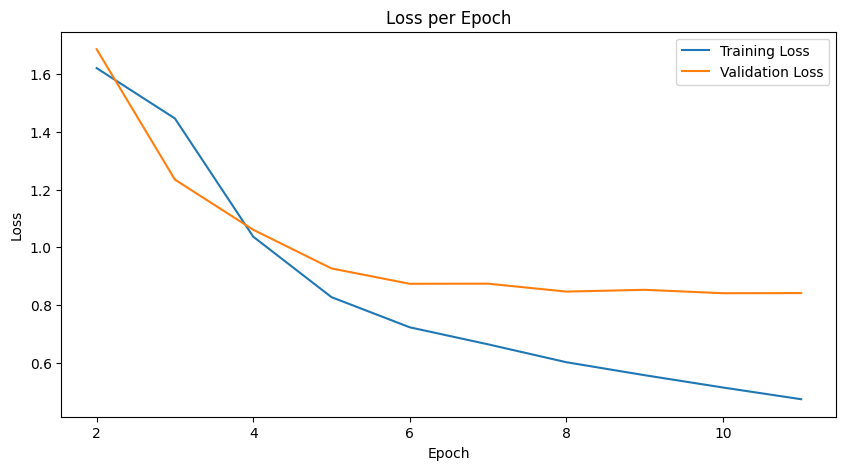

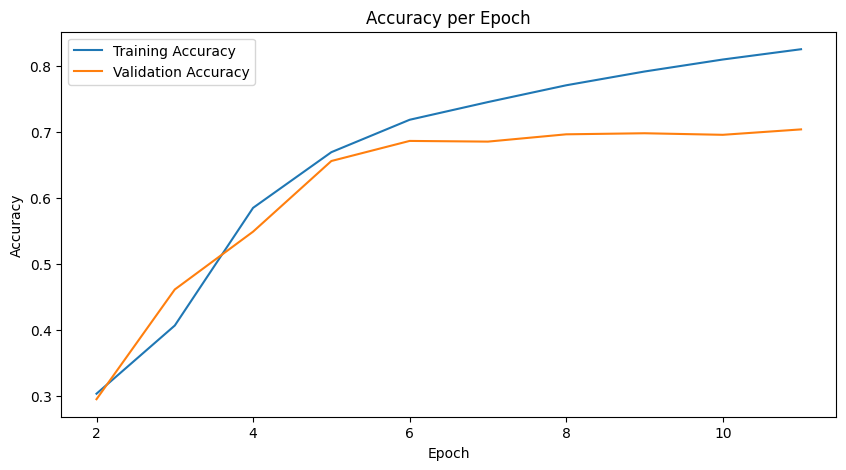

In [32]:
def plot_graphs(training_log):
    # Load the log file
    with open(training_log, "r") as f:
        history = json.load(f)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["train_loss"], label="Training Loss")
    plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history["epoch"], history["train_accuracy"], label="Training Accuracy")
    plt.plot(history["epoch"], history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_graphs(training_log_filepath)

# Step 4: Test the model

In [37]:
rawtext_test = ["i wanna kill my self"]
sequence_test = padding_func(tf.data.Dataset.from_tensors(vectorizer.tokenize(rawtext_test)))
for element in sequence_test:
    print(element)
predictions = model.predict(sequence_test)

# predictions will be a numpy array of shape (1, num_classes) with probabilities for each class
print(predictions)

# To get the predicted class index
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
print(f"Predicted class: {label_encoder.get_vocabulary()[predicted_class_index]}")

tf.Tensor(
[[  11 1302 1962 ...  528 4325  131]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]], shape=(500, 7), dtype=int32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
[[0.24172525 0.09034508 0.3647559  ... 0.06767116 0.10807944 0.10305205]
 [0.08738638 0.5461277  0.13344844 ... 0.03273793 0.08831949 0.03597964]
 [0.08738638 0.5461277  0.13344844 ... 0.03273793 0.08831949 0.03597964]
 ...
 [0.08738638 0.5461277  0.13344844 ... 0.03273793 0.08831949 0.03597964]
 [0.08738638 0.5461277  0.13344844 ... 0.03273793 0.08831949 0.03597964]
 [0.08738638 0.5461277  0.13344844 ... 0.03273793 0.08831949 0.03597964]]
Predicted class: Suicidal


# Step 5: Done, save the model

In [39]:
# Run this if you happy with the model
with open(data_dir+"/label_vocabulary.txt", "w") as f:
    for label in label_encoder.get_vocabulary():
        f.write(label + "\n")

model.save(data_dir+'/LSTM_low_dense.keras')